In [10]:
# STEP 1: Импорты и подключение Google Диска
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader

# STEP 2: Загрузка и подготовка данных
wadi_path = '/content/drive/MyDrive/Anomaly Detection Project/WADI_14days_new.csv'
wadi_df = pd.read_csv(wadi_path, nrows=5000)

# Удаляем нечисловые/лишние колонки
wadi_df = wadi_df.drop(columns=["Row", "Date", "Time"], errors='ignore')

# Удаляем колонки с >50% пропусков
wadi_df = wadi_df.loc[:, wadi_df.isnull().mean() < 0.5]

# Заполняем оставшиеся пропуски средними значениями
wadi_df = wadi_df.fillna(wadi_df.mean(numeric_only=True))

# Масштабируем
scaler = MinMaxScaler()
wadi_scaled = scaler.fit_transform(wadi_df)

# Преобразуем в тензоры
X_tensor = torch.tensor(wadi_scaled, dtype=torch.float32)

# Фейковые метки — все нули (SNN требует метки)
y_tensor = torch.zeros(X_tensor.shape[0], dtype=torch.long)

# Проверка
print(f"X shape: {X_tensor.shape}")
print(f"y shape: {y_tensor.shape}")

# STEP 3: DataLoader
batch_size = 128
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
X shape: torch.Size([5000, 123])
y shape: torch.Size([5000])


In [31]:
# Установка snntorch (если ещё не установлен)
!pip install snntorch --quiet

# Импорты
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
import torch.nn as nn

# Параметры модели
num_inputs = X_tensor.shape[1]
num_hidden = 64
num_outputs = 2  # Два класса (нормальный/аномалия — пусть будут пока фиктивные)

# Определим SNN модель
class SNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=0.9)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=0.9)

    def forward(self, x, num_steps=10):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        spk2_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)

        return torch.stack(spk2_rec)

model = SNNModel()

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = SF.mse_count_loss(correct_rate=0.8)

# Обучение
num_epochs = 5
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    for data, targets in loader:
        print(f"Input batch shape before view: {data.shape}")
        data = data.view(data.size(0), -1)
        print(f"Input batch shape after view: {data.shape}")

        spk_rec = model(data)

        loss_val = loss_fn(spk_rec, targets)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        total_loss += loss_val.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")



Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.Size([128, 123])
Input batch shape after view: torch.Size([128, 123])
Input batch shape before view: torch.

spk_rec shape: torch.Size([10, 128, 2])
Sum spikes per output neuron for sample 0: tensor([9., 0.])


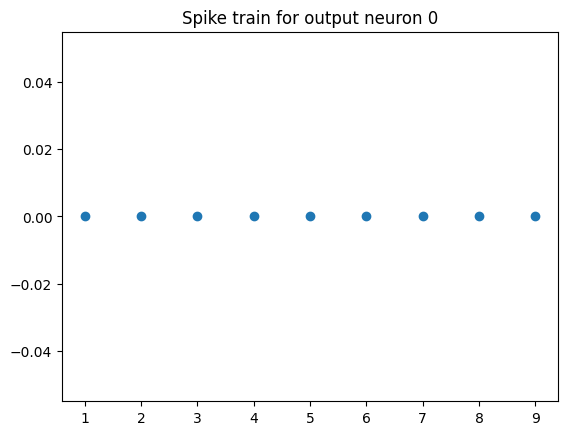

In [32]:
import matplotlib.pyplot as plt
from snntorch import spikeplot as splt

model.eval()

# Возьмём пару батчей из загрузчика
data_iter = iter(loader)
data_sample, targets_sample = next(data_iter)

with torch.no_grad():
    data_sample = data_sample.view(data_sample.size(0), -1)
    spk_rec = model(data_sample, num_steps=10)

# spk_rec размер: (num_steps, batch_size, num_outputs)
print(f"spk_rec shape: {spk_rec.shape}")

# Берём суммарные спайки по времени для первого примера в батче
spikes_sum = spk_rec[:, 0, :].sum(dim=0)
print(f"Sum spikes per output neuron for sample 0: {spikes_sum}")

# Визуализируем спайки первого выходного нейрона
fig, ax = plt.subplots()
splt.raster(spk_rec[:, 0, 0], ax=ax)
ax.set_title("Spike train for output neuron 0")
plt.show()


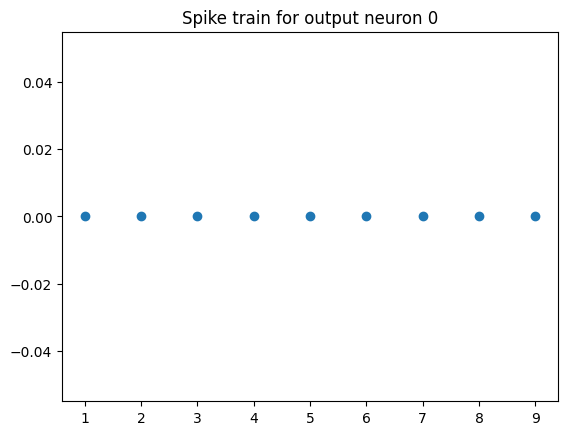

In [33]:
spike_train = spk_rec[:, 0, 0].round().to(torch.bool)
fig, ax = plt.subplots()
splt.raster(spike_train, ax=ax)
ax.set_title("Spike train for output neuron 0")
plt.show()


In [34]:
print(spk_rec[:, 0, 0])

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


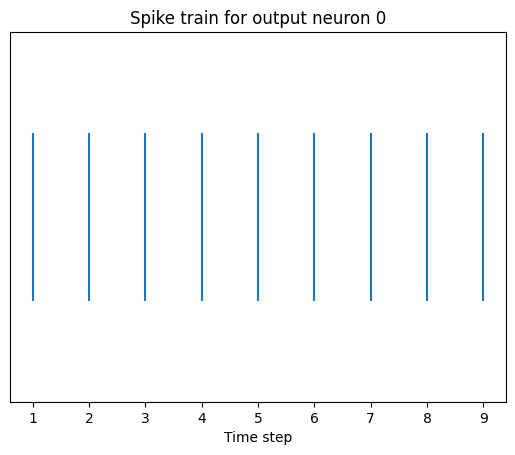

In [35]:
import numpy as np
import matplotlib.pyplot as plt

spike_train = spk_rec[:, 0, 0].cpu().numpy()

plt.eventplot(np.where(spike_train == 1)[0])
plt.title("Spike train for output neuron 0")
plt.xlabel("Time step")
plt.yticks([])
plt.show()


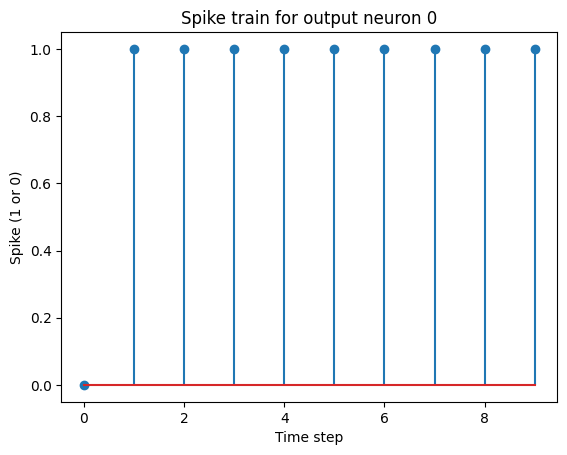

In [36]:
plt.stem(range(len(spike_train)), spike_train)
plt.title("Spike train for output neuron 0")
plt.xlabel("Time step")
plt.ylabel("Spike (1 or 0)")
plt.show()


In [37]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Проверяем, что model существует
try:
    net = model
except NameError:
    raise RuntimeError("Model 'model' is not defined! Сначала нужно создать модель.")

net.to(device)
net.eval()

with torch.no_grad():
    outputs = net(X.to(device))
    _, predicted = torch.max(outputs, 1)

y_true = y.cpu().numpy()
y_pred = predicted.cpu().numpy()

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')  # Для мульткласса
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


Using device: cuda


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x0 and 123x64)

In [30]:
print(f"Shape of X: {X.shape}")
print("wadi_df shape:", wadi_df.shape)
print("wadi_df columns:", wadi_df.columns)
print("First row:", wadi_df.iloc[0])
print("X shape before conversion to tensor:", wadi_df.values.shape)


Shape of X: torch.Size([0])
wadi_df shape: (5000, 123)
wadi_df columns: Index(['1_AIT_001_PV', '1_AIT_002_PV', '1_AIT_003_PV', '1_AIT_004_PV',
       '1_AIT_005_PV', '1_FIT_001_PV', '1_LS_001_AL', '1_LS_002_AL',
       '1_LT_001_PV', '1_MV_001_STATUS',
       ...
       '3_MV_001_STATUS', '3_MV_002_STATUS', '3_MV_003_STATUS',
       '3_P_001_STATUS', '3_P_002_STATUS', '3_P_003_STATUS', '3_P_004_STATUS',
       'LEAK_DIFF_PRESSURE', 'PLANT_START_STOP_LOG',
       'TOTAL_CONS_REQUIRED_FLOW'],
      dtype='object', length=123)
First row: 1_AIT_001_PV                171.155000
1_AIT_002_PV                  0.619473
1_AIT_003_PV                 11.575900
1_AIT_004_PV                504.645000
1_AIT_005_PV                  0.318319
                               ...    
3_P_003_STATUS                1.000000
3_P_004_STATUS                1.000000
LEAK_DIFF_PRESSURE           67.965100
PLANT_START_STOP_LOG          1.000000
TOTAL_CONS_REQUIRED_FLOW      0.680000
Name: 0, Length: 123, dtype: f